In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Loading data

In [2]:
from coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from image_utils import image_from_url


In [3]:
data = load_coco_data(pca_features=False)

In [4]:
def show_image(batch_size):
    captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
    for i, (caption, url) in enumerate(zip(captions, urls)):
        plt.imshow(image_from_url(url))
        plt.axis('off')
        caption_str = decode_captions(caption, data['idx_to_word'])
        plt.title(caption_str)
        plt.show()    

In [5]:
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_features <class 'numpy.ndarray'> (82783, 4096) float32
val_features <class 'numpy.ndarray'> (40504, 4096) float32
word_embedding <class 'numpy.ndarray'> (1004, 304) float64
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_image_idxs <class 'numpy.ndarray'> (400135,) int32


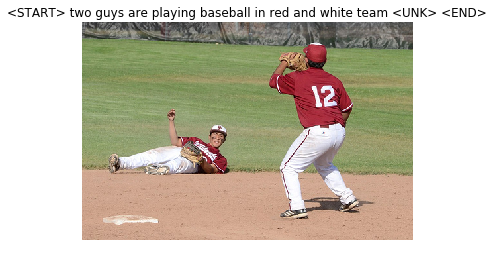

In [6]:
show_image(1)

In [7]:
def group_image_index_by_image_id(image_ids_in_caption_data_order):
    """
        Group image index, which is the same index position as corresponding caption data, by image id.
        i.e {8731 : [0,60,99,305]} caption and image features at these 4 positions correspond to image id 8731
    """
    image_positions_by_image_id = {}
    for i, img_id in enumerate(image_ids_in_caption_data_order):
        if img_id in image_positions_by_image_id:
            image_positions_by_image_id[img_id].append(i)
        else:
            image_positions_by_image_id[img_id] = [i]
    return image_positions_by_image_id

def map_image_index_to_captions(caption_data, grouped_image_index):
    """
        For each image id "key", get its corresponding captions, retrieved by "value" of the image instance indices.
        Image instance indices is assumed to be in the same order as the caption data.
    """
    captions_by_image_id = {}
    for k, v in grouped_image_index.items():
        captions_by_image_id[k] = caption_data[v]
    return captions_by_image_id

def scramble_image_caption_pairs(caption_data, grouped_image_index):    
    to_shuffle_caption = np.copy(caption_data)
    np.random.shuffle(to_shuffle_caption)
    return map_image_index_to_captions(to_shuffle_caption, grouped_image_index)

def flatten_image_caption_groups(grouped_captions):
    all_captions = []
    all_image_ids = []
    for k, v in grouped_captions.items():
        all_image_ids += [k] * len(v) # duplicate lables
        all_captions.append(v)
    flat_image_ids = np.array(all_image_ids)
    flat_captions = np.concatenate(all_captions, axis=0)
    assert flat_image_ids.shape[0] == flat_captions.shape[0]
    return flat_image_ids, flat_captions

def merge_demo_sampled(demo_image, demo_caption, sample_image, sample_caption):
    is_demo = np.ones(demo_image.shape)
    is_sample = np.ones(sample_image.shape) * -1
    return np.concatenate([demo_image, sample_image], axis=0), np.concatenate([demo_caption, sample_caption], axis=0), np.concatenate([is_demo, is_sample], axis=0)

def remove_start_token(captions_with_start_token):
    return np.array([c[1:] for c in captions_with_start_token])


In [8]:
# minibatch
class MiniBatcher(object):
    def __init__(self, batchable_tuple):
        shapes = [b.shape[0] for b in batchable_tuple]
        assert all([s == shapes[0] for s in shapes]), "Data to be batched together should have the same first dimension"
        self.batchable_tuple = batchable_tuple
        self.data_size = shapes[0]
    
    def sample(self, batch_size=100):
        assert batch_size <= self.data_size
        mask = np.random.choice(self.data_size, batch_size)
        batch_list = [b[mask] for b in self.batchable_tuple]
        return tuple(batch_list)

In [9]:
image_ids = data['train_image_idxs']
captions = data['train_captions']
idx_to_word = data['idx_to_word']

# create random pairing
grouped_image_index = group_image_index_by_image_id(image_ids)
grouped_captions = map_image_index_to_captions(captions, grouped_image_index)
scrambled_captions = scramble_image_caption_pairs(captions, grouped_image_index)

# merge both, and retain flag
image_idx_demo, captions_demo = flatten_image_caption_groups(grouped_captions)
image_idx_sampled, caption_sampled = flatten_image_caption_groups(scrambled_captions)

demo_batcher = MiniBatcher((image_idx_demo, captions_demo, np.ones(image_idx_demo.shape)))
sample_batcher = MiniBatcher((image_idx_sampled, caption_sampled, np.ones(image_idx_sampled.shape) * -1))

In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import layer_utils 

## Model Param

In [11]:

## word preprocess
vocab_dim = len(data['word_to_idx'])
image_feature_dim = data['val_features'].shape[1]
enable_preprocessed_embedding = True

if enable_preprocessed_embedding:
    word_embedding_dim = data['word_embedding'].shape[1]
else:
    word_embedding_dim = 256

START_TOKEN = '<START>'
END_TOKEN = '<END>'
NULL_TOKEN = '<NULL>'
UNK_TOKEN = '<UNK>'
NULL_ID = data['word_to_idx'][NULL_TOKEN]
START_ID = data['word_to_idx'][START_TOKEN]
END_ID = data['word_to_idx'][END_TOKEN]
UNK_ID = data['word_to_idx'][UNK_TOKEN]

## model params
hidden_dim = 512
learning_rate = 1e-3

print("Vocab Dim: %i\nImage Feature Dim: %i\nWord Embedding Dim: %i"%(vocab_dim, image_feature_dim, word_embedding_dim))

Vocab Dim: 1004
Image Feature Dim: 4096
Word Embedding Dim: 304


## Model Architecture

In [12]:
# Word Input


sy_caption_input = tf.placeholder(shape=[None, None], name="caption_input", dtype=tf.int32)

if enable_preprocessed_embedding:
    embedding_init = tf.constant(data['word_embedding'], dtype=tf.float32)
    embedding = tf.get_variable("embedding", initializer=embedding_init)
else:
    embedding_init = tf.random_normal_initializer()
    embedding = tf.get_variable("embedding", [vocab_dim, word_embedding_dim], dtype=tf.float32, initializer=embedding_init)

word_embedding = tf.nn.embedding_lookup(embedding, sy_caption_input)

# Image Input
sy_image_feat_input = tf.placeholder(shape=[None, image_feature_dim], name="image_feat_input", dtype=tf.float32)
image_projection = layer_utils.affine_transform(sy_image_feat_input, hidden_dim, 'image_proj')
initial_cell_state = image_projection * 0

# LSTM states
sy_hidden_state = tf.placeholder(shape=[None, hidden_dim], name="hidden_lstm_state", dtype=tf.float32)
sy_cell_state = tf.placeholder(shape=[None, hidden_dim], name="cell_lstm_state", dtype=tf.float32)

sy_is_initial_step = tf.placeholder(tf.int32, shape=[], name="is_initial_step")

initial_lstm_state = tf.nn.rnn_cell.LSTMStateTuple(image_projection * 0, image_projection)

In [13]:
# LSTM

use_bidirectional = True
if use_bidirectional:
    cell_fw = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    cell_bw = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    bi_output, _ = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, word_embedding, initial_state_bw=initial_lstm_state, initial_state_fw=initial_lstm_state, time_major=False, dtype=tf.float32)
    lstm_output = tf.concat([bi_output[0], bi_output[1]], axis=2)
else:
    cell = tf.nn.rnn_cell.LSTMCell(hidden_dim)
    lstm_output, output_cell_state = tf.nn.dynamic_rnn(cell, word_embedding, time_major=False, dtype=tf.float32, initial_state=initial_lstm_state)

incremental_change = layer_utils.difference_over_time(lstm_output, "incremental_change")
hidden_to_reward = tf.squeeze(layer_utils.affine_transform(incremental_change, 1, 'hidden_to_reward'), axis=2)
# hidden_to_reward = tf.squeeze(layer_utils.build_mlp(lstm_output, 1, 'hidden_to_reward', activation=tf.nn.relu), axis=2)


# Apply not-null mask to ignore reward on trailing padding
sy_not_null_mask = tf.placeholder(shape=[None, None], name="mask_not_null", dtype=tf.bool)
sy_is_demo = tf.placeholder(shape=[None], name="is_demo", dtype=tf.float32)
expanded_is_demo = tf.expand_dims(sy_is_demo, dim=1)
numeric_mask_not_null = tf.cast(sy_not_null_mask, dtype=tf.float32)
masked_reward = hidden_to_reward * numeric_mask_not_null
negated_sample_reward = expanded_is_demo * masked_reward # the higher reward to demo, the lower reward to sampled
total_not_null = tf.cast(tf.reduce_sum(numeric_mask_not_null, axis=1), tf.float32)
mean_reward_for_each_sentence = tf.reduce_sum(negated_sample_reward, axis=1) / total_not_null
mean_reward = tf.reduce_mean(mean_reward_for_each_sentence)

update_op = tf.train.AdamOptimizer(learning_rate).minimize(mean_reward * -1) # maximize the reward

print("-- Input tensors --")
print("word embedding shape: ", word_embedding)
# print("bidiretional output layer: ", bi_output)
print("lstm_output output: ", lstm_output)
print("hidden reward: ", hidden_to_reward)

print("\n-- Loss tensors --")
print("Mask not null: ", numeric_mask_not_null)
print("Is demo null: ", sy_is_demo)
print("Total not null: ", total_not_null)
print("Masked reward: ", masked_reward)
print("Negated sample reward: ", masked_reward)
print("Mean reward for each sentence: ", masked_reward)
print("Mean reward: ",  mean_reward)


-- Input tensors --
word embedding shape:  Tensor("embedding_lookup:0", shape=(?, ?, 304), dtype=float32)
lstm_output output:  Tensor("concat:0", shape=(?, ?, 1024), dtype=float32)
hidden reward:  Tensor("Squeeze:0", shape=(?, ?), dtype=float32)

-- Loss tensors --
Mask not null:  Tensor("Cast:0", shape=(?, ?), dtype=float32)
Is demo null:  Tensor("is_demo:0", shape=(?,), dtype=float32)
Total not null:  Tensor("Sum:0", shape=(?,), dtype=float32)
Masked reward:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Negated sample reward:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Mean reward for each sentence:  Tensor("mul_2:0", shape=(?, ?), dtype=float32)
Mean reward:  Tensor("Mean:0", shape=(), dtype=float32)


## Training

In [14]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [29]:
def get_image_features(image_ids):
    return data['train_features'][image_ids]

def process_mini_batch(batcher1, batcher2, batch_size):
    image_idx_batch1, caption_batch1, demo_or_sampled_batch1 = batcher1.sample(batch_size)
    image_idx_batch2, caption_batch2, demo_or_sampled_batch2 = batcher2.sample(batch_size)
    image_idx_batch = np.concatenate([image_idx_batch1, image_idx_batch2], axis=0)
    caption_batch = np.concatenate([caption_batch1, caption_batch2], axis=0)
    
    demo_or_sampled_batch = np.concatenate([demo_or_sampled_batch1, demo_or_sampled_batch2], axis=0)
    not_null_mask_batch = caption_batch != NULL_ID
    # to randomize here
    
    return image_idx_batch, caption_batch, not_null_mask_batch, demo_or_sampled_batch

iter_num = 100
batch_size = 1000
for i in range(iter_num):
    
    image_idx_batch, caption_batch, not_null_mask, demo_or_sampled_batch = process_mini_batch(
        demo_batcher, 
        sample_batcher,
        batch_size
    )
    image_feats_batch = get_image_features(image_idx_batch)

    _, r, m, me = sess.run([update_op, mean_reward, negated_sample_reward, mean_reward_for_each_sentence], feed_dict=
                       {sy_image_feat_input: image_feats_batch,
                        sy_caption_input: caption_batch, 
                        sy_not_null_mask: not_null_mask,
                        sy_is_demo: demo_or_sampled_batch
                       })
    if i % 20 == 0:
        print("iter {}, reward: {}".format(i,r))

iter 0, reward: 11.376254081726074
iter 20, reward: 13.445262908935547
iter 40, reward: 16.640365600585938
iter 60, reward: 22.091569900512695
iter 80, reward: 25.791698455810547


In [16]:
demo_or_sampled_batch[846], decode_captions(caption_batch[846], idx_to_word), 

(1.0, '<START> <UNK> male skateboarding on <UNK> at a skate park <END>')

In [17]:
def test_run(img_feature_test, caption_test):
    not_null_mask_test = caption_test != NULL_ID
    m = sess.run(masked_reward, feed_dict=
                   {sy_image_feat_input: img_feature_test,
                    sy_caption_input: caption_test, 
                    sy_not_null_mask: not_null_mask_test})
    sum_not_null = np.sum(not_null_mask_test, axis=1)
    me = np.sum(m, axis=1) / sum_not_null
    return m, me
                           
def convert_to_word_ids(captions):
    max_len = max([len(c) for c in captions])
    caption_ids = np.ones((len(captions), max_len), dtype=np.int) * NULL_ID
    for i, c in enumerate(captions):
        for j, tk in enumerate(c):
            if tk in data['word_to_idx']:
                caption_ids[i, j] = data['word_to_idx'][tk]
            else:
                caption_ids[i, j] = UNK_ID
    return caption_ids

def assign_reward(img_ids, captions):
    image_feats_test = get_image_features(img_ids)
    caption_test = convert_to_word_ids(captions)
    reward_per_token, mean_reward = test_run(image_feats_test, caption_test)
    examine(img_ids, caption_test, reward_per_token, mean_reward)
    
def examine(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
    for (img, cap, r, me_r) in zip(chosen_img, chosen_caption, chosen_reward_per_token, chosen_mean_reward):
        print("Avg reward: ", me_r)
        plt.imshow(image_from_url(data['train_urls'][img]))
        plt.axis('off')
        plt.show()   
        decoded = decode_captions(cap, idx_to_word).split()
        for (i,j) in zip(decoded, r):
            print("{:<15} {}".format(i, j))

        print("- - - -")
    
def examine_batch_results(demo_or_sample, image_id, caption_batch, reward_per_token, mean_reward):
    num_to_examine = 4

    def examine_sample(chosen):
        print(chosen)
        chosen_img = image_id[chosen]
        chosen_cap = caption_batch[chosen]
        chosen_reward_per_token = reward_per_token[chosen]
        chosen_mean_reward = mean_reward[chosen]
        
        examine(chosen_img, chosen_cap, chosen_reward_per_token, chosen_mean_reward)
    
    print("DEMO RESULTS")    
    chosen = np.random.choice(np.where( demo_or_sampled_batch == 1 )[0], num_to_examine)
    examine_sample(chosen)
    print("\n\nSAMPLED RESULTS")
    chosen = np.random.choice(np.where( demo_or_sampled_batch == -1 )[0], num_to_examine)
    examine_sample(chosen)


Avg reward:  -18.9250270299


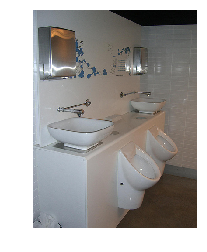

<START>         24.83979034423828
zoo             -21.751304626464844
with            9.414152145385742
<UNK>           -69.29769134521484
and             17.177631378173828
children        -78.78982543945312
<END>           -14.067947387695312
- - - -
Avg reward:  7.44318459251


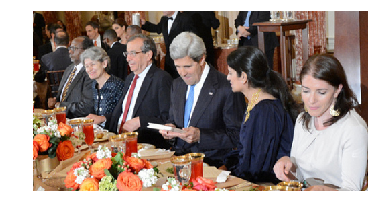

<START>         -119.99869537353516
people          46.897640228271484
are             -64.40880584716797
dining          55.18909454345703
and             -44.18294143676758
talking         60.25187301635742
on              -42.4274787902832
a               64.4101791381836
long            -22.954757690429688
table           111.35175323486328
<END>           37.74716567993164
- - - -


In [43]:
image_to_test = np.array([99, 1010])
captions_to_test = ["<START> zoo with monkey and children <END>".split(), "<START> people are dining and talking on a long table <END>".split()]
assign_reward(image_to_test, captions_to_test)

DEMO RESULTS
[135  30 395  36]
Avg reward:  35.2061


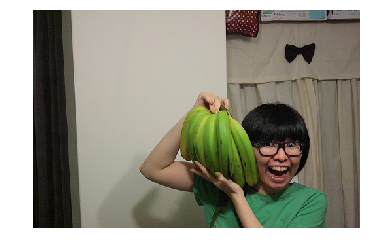

<START>         128.9875030517578
a               8.634871482849121
very            110.77739715576172
<UNK>           -50.66007995605469
woman           91.99116516113281
holds           -71.9165267944336
up              91.37028503417969
a               -69.07525634765625
bunch           98.62017059326172
of              -74.69274139404297
green           129.21200561523438
bananas         -55.243492126464844
<END>           119.67361450195312
- - - -
Avg reward:  74.7966


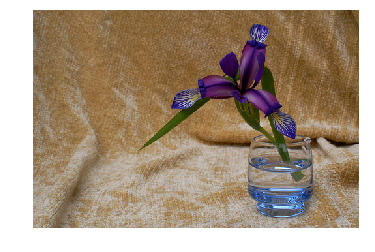

<START>         123.4885482788086
a               -6.075475215911865
water           106.55291748046875
glass           -48.425079345703125
filled          115.36297607421875
with            1.8143444061279297
purple          132.68597412109375
and             45.206260681152344
green           167.6077880859375
flowers         48.176029205322266
<END>           136.36837768554688
- - - -
Avg reward:  109.074


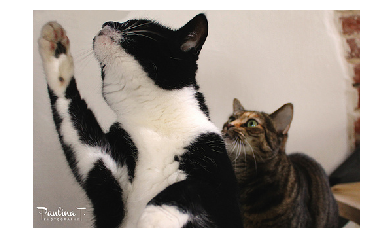

<START>         140.288330078125
a               28.33009910583496
white           156.184326171875
and             47.751251220703125
black           194.597900390625
cat             68.61810302734375
and             204.2429962158203
a               72.31141662597656
grey            196.90045166015625
<UNK>           44.89282989501953
cat             187.41964721679688
looking         24.172626495361328
<UNK>           144.484130859375
<END>           16.840112686157227
- - - -
Avg reward:  23.1959


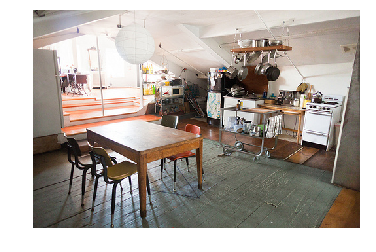

<START>         123.4996566772461
a               -13.997223854064941
kitchen         136.67697143554688
and             20.401033401489258
dining          143.38430786132812
room            9.43172550201416
table           94.10752868652344
have            -79.37632751464844
a               97.25721740722656
<UNK>           -160.03526306152344
roof            123.55604553222656
<END>           -216.5552215576172
- - - -


SAMPLED RESULTS
[1977 1046 1224 1191]
Avg reward:  30.1181


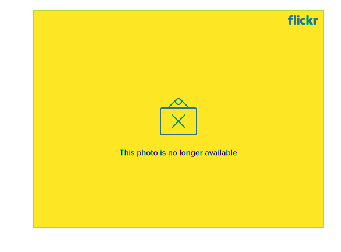

<START>         1.7412968873977661
a               -7.2837371826171875
man             16.764005661010742
and             43.20721435546875
a               -1.7155598402023315
women           83.16267395019531
standing        -24.551973342895508
next            90.86510467529297
to              -14.279684066772461
each            84.79515075683594
other           -17.41001319885254
<END>           106.12252807617188
- - - -
Avg reward:  -84.9159


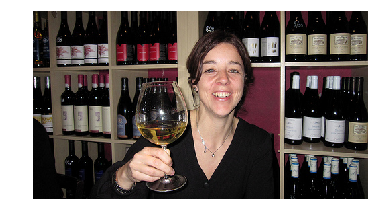

<START>         -126.16909790039062
<UNK>           18.883161544799805
<UNK>           -115.66960144042969
a               3.770249128341675
<UNK>           -106.48007202148438
traffic         -25.912033081054688
<UNK>           -103.25575256347656
between         -89.20635223388672
a               -146.79034423828125
bus             -88.92766571044922
and             -139.51031494140625
a               -95.60185241699219
car             -120.8028335571289
<END>           -53.1499137878418
- - - -
Avg reward:  -57.395


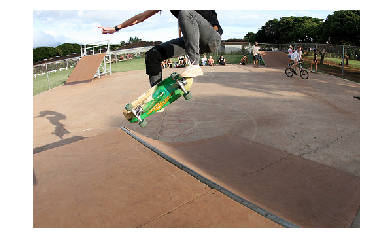

<START>         -42.927764892578125
a               3.088212013244629
large           -79.49434661865234
stove           -2.457326650619507
top             -101.12161254882812
with            8.006422996520996
a               -94.95550537109375
<UNK>           12.764933586120605
<UNK>           -90.26919555664062
sitting         -12.308491706848145
on              -144.0889434814453
top             -45.09259796142578
of              -152.25271606445312
the             -27.596887588500977
<UNK>           -124.14453125
<END>           -25.470239639282227
- - - -
Avg reward:  28.7714


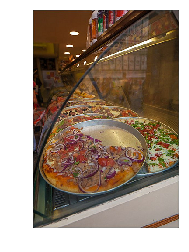

<START>         -18.838403701782227
some            14.21051025390625
girls           -18.857378005981445
are             74.17996978759766
playing         -27.29132652282715
<UNK>           115.90568542480469
on              -45.523643493652344
a               100.14329528808594
court           -31.772972106933594
<END>           125.55819702148438
- - - -


In [31]:
examine_batch_results(demo_or_sampled_batch, image_idx_batch, caption_batch, m, me)

#### Bidirectional with tanh doesn't do well, it seems to assign all the tokens in that category (all 1 or all neg 1) after 600 iter / 2000 bath size
#### Bidirectional without tanh seems to do qualitatively better - needs a metric that can compare across different methods
#### Uni-directional with difference of hidden states make results more discriminative at word levels
#### Bidirectional with difference of hidden states are also more disciminative

In [20]:
diff_func = lambda x1, x2 : x2-x1
tf.scan(diff_func, tf.constant([[12,3],[8,9]])).eval()

array([[12,  3],
       [-4,  6]], dtype=int32)